## Import libraries

In [1]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
import re
import os
import time
import math



### constants to sync with values in d435-capture.ipynb



In [2]:
depth_scale = 9.999999747378752e-05
#imgfolder = "D:/d435/manu-bear-20181027/"
imgfolder = "D:/d435/puzzle-box-848-20181027/"

width = 848
height = 480


### fetch all file names


In [3]:
filelist = sorted(os.listdir(imgfolder))

# ['c_1540534762479.1584.npy', 'c_1540534762645.808.npy', 'c_1540534762813.2444.npy', 
#  'd_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
#print(filelist)

timesteps = []
filetimes = []
color_files = []
depth_files = []
base_time = -1.0

for f in filelist:
    result = re.search('c_(.*).npy', f)
    if result and result.group(1):
        t = result.group(1)
        timesteps.append(float(t))
        if base_time < 0:
            base_time = float(t)
        filetimes.append(t)
        color_files.append(f)
        depth_files.append("d_" + t + ".npy")

#print(timesteps)
#print(depth_files)
print(len(depth_files))

997


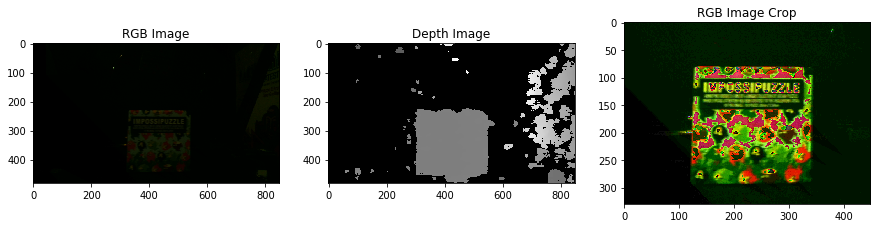

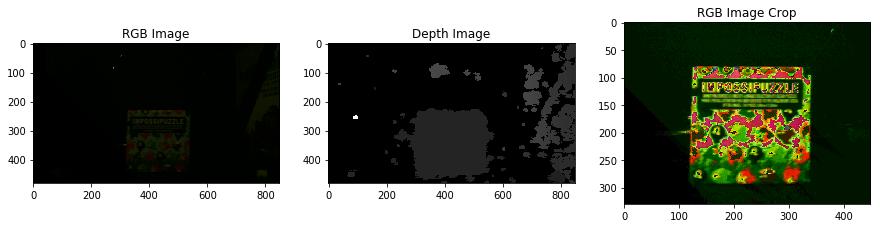

In [23]:
color_image = np.load(imgfolder + color_files[0])
depth_image = np.load(imgfolder + depth_files[0])


# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(depth_image, cmap='gray')

cimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
table3 = fig.add_subplot(1,3,3)
table3.set_title("RGB Image Crop")
table3.imshow(cimage[150:,200:648,:]*10)

color_image = np.load(imgfolder + color_files[49])
depth_image = np.load(imgfolder + depth_files[49])


# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(depth_image, cmap='gray')

cimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
table3 = fig.add_subplot(1,3,3)
table3.set_title("RGB Image Crop")
table3.imshow(cimage[150:,200:648,:]*10)


In [6]:
print(depth_image.shape)
print(depth_image[450,600])
print(depth_image[450,600]*depth_scale)

print(color_image.shape)
print(color_image[450,600])

max_depth = int(0.5/depth_scale)
print("Max Depth Int ",max_depth)

min_depth = int(0.2/depth_scale)
print("Min Depth Int ",min_depth)

(480, 848)
0
0.0
(480, 848, 3)
[0 2 0]
Max Depth Int  5000
Min Depth Int  2000


In [24]:
radian_size = 6283
h_fov = 69.4*math.pi/180
# the tangent constant for the FOV/2 of the camera
fov_tan = math.tan(h_fov/2)
print("fov tan",fov_tan)
print("depth scale",depth_scale)
# distance between turntable center and camera
# Sony turntable distance = 31cm
turn_dist = 0.31

# 33.33 rpm = 3.49065846509342 rad/s
rotate_speed = 3.49065846509342

cylinder_depth = np.zeros((720,radian_size), dtype=float)
cylinder_count = np.zeros((720,radian_size), dtype=int)
cylinder_r = np.zeros((720,radian_size), dtype=float)
cylinder_g = np.zeros((720,radian_size), dtype=float)
cylinder_b = np.zeros((720,radian_size), dtype=float)


#    x′ = x cos ⁡ θ − y sin ⁡ θ
#    y′ = x sin ⁡ θ + y cos ⁡ θ
point_count = 0
max_coord = 0
min_coord = 1000000

#for n in range(len(depth_files)):
for n in range(49):
    print("Processing ",n," file ",color_files[n])
    color_image = np.load(imgfolder + color_files[n])
    depth_image = np.load(imgfolder + depth_files[n])
    # timedelta is in seconds
    time_delta = (timesteps[n] - base_time)/1000
    angle_delta = (time_delta * rotate_speed) % (2*math.pi)
    print(angle_delta)
    #print(depth_image[450,180])
    for x in range(200,width-200):
        for z in range(150,height):
            y = depth_image[z,x]
            if max_coord < y:
                max_coord = y
            if min_coord > y:
                min_coord = y

            r = color_image[z,x,2]
            g = color_image[z,x,1]
            b = color_image[z,x,0]
            # cam_y is in metres
            cam_y = y * depth_scale
            if cam_y < 0.05:
                continue
            if cam_y > (turn_dist*1.4):
                continue
            # x in camera coord
            cam_x = ((x - (width/2))/(width/2)) * cam_y *  fov_tan
            # convert to center of turntable coordinates
            turn_x = cam_x
            turn_y = cam_y - turn_dist
            # rotate by angle_delta
            rot_x = turn_x * math.cos(angle_delta) - turn_y * math.sin(angle_delta)
            rot_y = turn_x * math.sin(angle_delta) + turn_y * math.cos(angle_delta)            
            # rot_radius = depth is now distance from the turntable center
            # rot_angle is between -pi and pi
            rot_radius = math.sqrt(rot_x*rot_x + rot_y*rot_y)
            rot_angle = math.atan2(rot_y, rot_x)
            rot_coord = int(radian_size * (rot_angle + math.pi)/(2*math.pi))
            
            # record into the arrays
            if cylinder_count[z, rot_coord] > 0:
                count = cylinder_count[z, rot_coord]
                cylinder_depth[z, rot_coord] = ((cylinder_depth[z, rot_coord] * count) + rot_radius) / (count + 1)
                cylinder_r[z, rot_coord] = ((cylinder_r[z, rot_coord] * count) + r) / (count + 1)
                cylinder_g[z, rot_coord] = ((cylinder_g[z, rot_coord] * count) + g) / (count + 1)
                cylinder_b[z, rot_coord] = ((cylinder_b[z, rot_coord] * count) + b) / (count + 1)
            else:
                cylinder_depth[z, rot_coord] = rot_radius
                cylinder_r[z, rot_coord] = r
                cylinder_g[z, rot_coord] = g
                cylinder_b[z, rot_coord] = b
            cylinder_count[z, rot_coord] += 1
            #if max_coord < rot_coord:
            #    max_coord = rot_coord
            #if min_coord > rot_coord:
            #    min_coord = rot_coord
            point_count += 1
    print("Point count", point_count)
    point_count = 0
            
print("Done")
#print("Point count", point_count)
#print("Max Min ", max_coord, " ", min_coord)

fov tan 0.69243282809315
depth scale 9.999999747378752e-05
Processing  0  file  c_1540627635557.1392.npy
0.0
Point count 59383
Processing  1  file  c_1540627635590.236.npy
0.11553005732919665
Point count 59524
Processing  2  file  c_1540627635624.1655.npy
0.23396615600750675
Point count 62953
Processing  3  file  c_1540627635657.5002.npy
0.35032626737601025
Point count 55383
Processing  4  file  c_1540627635724.8257.npy
0.5853363825191956
Point count 53133
Processing  5  file  c_1540627635758.4229.npy
0.7026126212924783
Point count 57172
Processing  6  file  c_1540627635791.79.npy
0.8190860767957125
Point count 61760
Processing  7  file  c_1540627635825.425.npy
0.9364944083575912
Point count 55461
Processing  8  file  c_1540627635859.196.npy
1.0543774217468764
Point count 52372
Processing  9  file  c_1540627635892.6619.npy
1.171195170712
Point count 52134
Processing  10  file  c_1540627635926.277.npy
1.2885344731391932
Point count 58577
Processing  11  file  c_1540627635959.7087.npy
1.

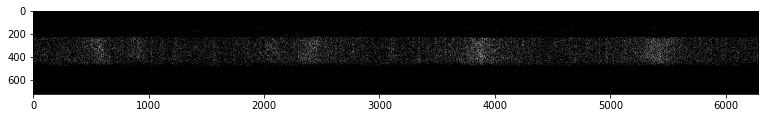

In [61]:
fig = plt.figure(figsize=(13, 13))
plt.imshow(cylinder_count, cmap='gray')
plt.show()


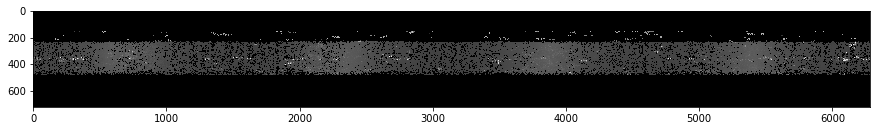

In [47]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_depth, cmap='gray')
plt.show()


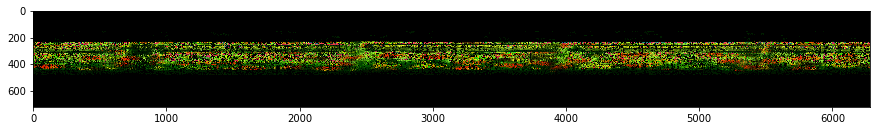

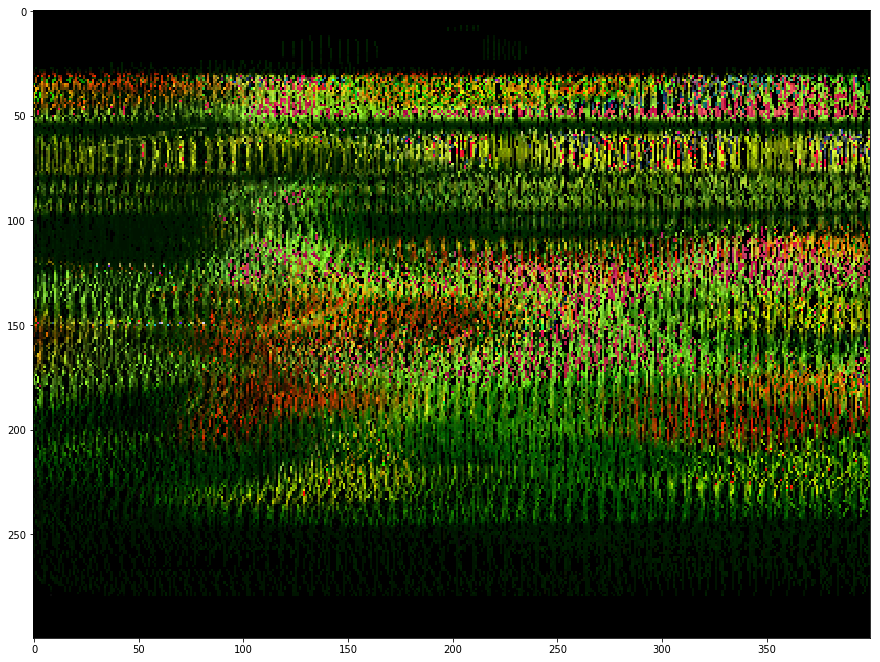

In [64]:
rgbArray = np.zeros((720,radian_size,3), 'uint8')
rgbArray[..., 0] = cylinder_r*10
rgbArray[..., 1] = cylinder_g*10
rgbArray[..., 2] = cylinder_b*10

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray)
plt.show()

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray[200:500,800:1200,:])
plt.show()


In [71]:
x_view = np.zeros((720,4000,3), dtype=float)
y_view = np.zeros((720,4000,3), dtype=float)

xmax = -100000
ymax = -100000
xmin = 100000
ymin = 100000


for r in range(radian_size):
    for z in range(150,height):
        cr = rgbArray[z,r,0]
        cg = rgbArray[z,r,1]
        cb = rgbArray[z,r,2]
        d = cylinder_depth[z,r]
        count = cylinder_count[z,r]
        # get back to x and y from rot_coord and depth
        if (d > 0.0) and (count > 0):
            rot_angle = ((r / radian_size) * (2*math.pi))
            x = d * math.cos(rot_angle) / depth_scale
            y = d * math.sin(rot_angle) / depth_scale
            #print(x)
            if (x > xmax):
                xmax = x
            if (y > ymax):
                ymax = y
            if (x < xmin):
                xmin = x
            if (y < ymin):
                ymin = y
            xcoord = int(x+2000)
            ycoord = int(y+2000)
            x_view[z,xcoord,0] = cr
            y_view[z,ycoord,0] = cr
            x_view[z,xcoord,1] = cg
            y_view[z,ycoord,1] = cg
            x_view[z,xcoord,2] = cb
            y_view[z,ycoord,2] = cb

print("xmax",xmax)
print("ymax",ymax)
print("xmin",xmin)
print("ymin",ymin)

            

xmax 1930.07639265
ymax 1775.08604412
xmin -1768.08346104
ymin -1701.52650708


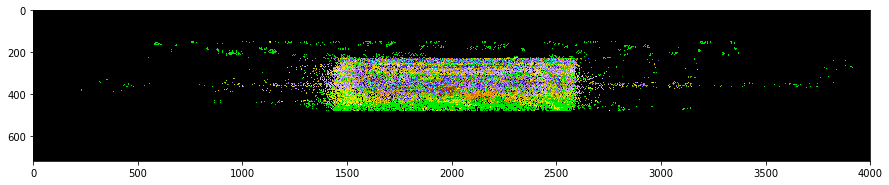

In [73]:
x_view_clip = np.zeros((720,4000,3), dtype=float)
np.clip(x_view, 0, 255, out=x_view_clip)

y_view_clip = np.zeros((720,4000,3), dtype=float)
np.clip(y_view, 0, 255, out=y_view_clip)

fig = plt.figure(figsize=(15, 15))
plt.imshow(x_view_clip[:,:,:])
plt.show()
